# Recommending Movies
**Content:**
  * Introduction
  * Exploratory analysis
  * Collaborative Filtering
    * Results
  * Matrix Factorization
    * Results
  * Comparison of both methods
  * Conclusion
  * Next steps
  
## Introduction
We all know the famous <a href="https://en.wikipedia.org/wiki/Netflix_Prize">Netflix challenge</a>, where people competed to build the best recommendation engine for movie ratings. Luckily for us, the data are available, so we all can have a bit of fun.

In this notebook, I will approach the problem in two ways:
  * **Collaborative Filtering** (user and item based)
  * **Matrix Factorizatin** (using simple SVD)
  
The idea is to build and compare the two methods. There are many great articles about the algorithms, use-cases and explanations, hence I will omit those and focus only on the methods and caveats I encountered.

Regarding the **evaluation**, three methods will be used: **(i)**RMSE, **(ii)**top-n movies users liked and we think he/she will like and **(iii)**most similar movies. I have chosen those three because they complement each other. RMSE gives one easily comparable number, whilest the other two show the usefulness in practice.

Only explicit ratings are used.

The analysis is done using Python 2.7 (Anaconda distribution). The data are available here: http://files.grouplens.org/datasets/movielens/ml-100k.zip

**Sources I have used**:
  * I found quite some blog posts, which built the very same thing. All extremely useful and some very impressive (the second and third especially)
    * https://cambridgespark.com/content/tutorials/implementing-your-own-recommender-systems-in-Python/index.html
    * http://blog.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/
    * http://blog.ethanrosenthal.com/2016/01/09/explicit-matrix-factorization-sgd-als/
    * https://beckernick.github.io/matrix-factorization-recommender/
  * StackOverflow
  * My notes from Data Mining course at KULeuven from summer 2017

The first thing is to load the data and modify them a bit. The item dataset contains dummy columns for each type of genre, so I convert those into one column describing the movie.

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error as MSE
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import seaborn as sns

#Make the print nice
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.set_printoptions(linewidth=100, precision=4,suppress=True)

header = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('C:/Users/Honza/Desktop/Projects/Rec_engine/ml-100k/u.data', sep='\t', names=header)

header_movies = ['movie id','movie title','release date','video release date',
                 'IMDb URL','unknown','Action','Adventure','Animation','Childrens',
                 'Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir',
                 'Horror','Musical','Mystery','Romance','Sci-Fi','Thriller',
                 'War','Western']
df_movies = pd.read_csv('C:/Users/Honza/Desktop/Projects/Rec_engine/ml-100k/u.item', sep='|', names=header_movies)

'''#####
Create new column which shows genre(s) of the movie
#####'''
#Replace 1/0 with genre name
genre_headers = header_movies[5:]
for genre in genre_headers:
    df_movies[genre] = np.where(df_movies[genre] == 1,genre + str(','), '')
    
#Concatane all the genre columns
df_movies['genre'] = df_movies[genre_headers].astype(str).sum(axis=1)

#Remove the last comma
df_movies['genre'] = df_movies['genre'].str[:-1]

print df_movies[['movie id','movie title','release date', 'genre']].head(n=5)

height has been deprecated.

   movie id        movie title release date                       genre
0         1   Toy Story (1995)  01-Jan-1995  Animation,Childrens,Comedy
1         2   GoldenEye (1995)  01-Jan-1995   Action,Adventure,Thriller
2         3  Four Rooms (1995)  01-Jan-1995                    Thriller
3         4  Get Shorty (1995)  01-Jan-1995         Action,Comedy,Drama
4         5     Copycat (1995)  01-Jan-1995        Crime,Drama,Thriller


## Exploratory analysis
Let's start with a quick look at the data. This dataset is only a sample of the data used for the competition (if I recall correctly, there was about 100M ratings). I also need to transform the data into user-item matrix.

In average, a user gave 106 ratings. When we have a look at the distribution, most people have rated something under 100 movies. Which is not much, considering there are 1682 movies. This is called **sparsity** problem. In our dataset, 93.7% ratings are missing.

Data sample:
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


Number of users: 943.
Number of movies: 1682.
Average number of ratings per user: 106.04
Sparsity: 93.7%


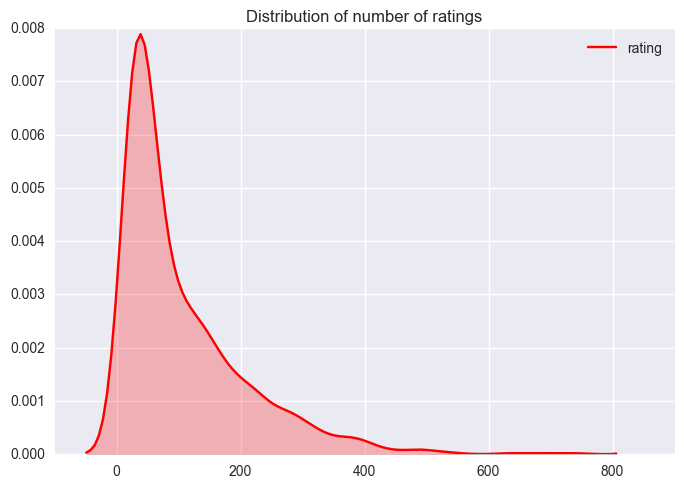

In [6]:
def createUserItemMatrix(X):
    ''' 
    Creates user-item matrix
    -----------------------
    X: pd DataFrame with input data
    ----------------------
    '''
    n_users = X.user_id.unique().shape[0]
    n_items = X.item_id.unique().shape[0]
    ratings = np.zeros((n_users, n_items))
    
    for row in X.itertuples():
        ratings[row[1]-1, row[2]-1]  = row[3]
    return ratings

ratings = createUserItemMatrix(df)

print 'Data sample:'
print df.head(n=5)
print '\n'

n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print 'Number of users: {}.'.format(n_users) 
print 'Number of movies: {}.'.format(n_items)
print 'Average number of ratings per user: {}'.format(round(np.mean(df.groupby(['user_id'])['rating'].count()),2))
print 'Sparsity: {}%'.format(round(1.0-len(df)/float(n_users*n_items),3)*100)

#distribution
sns.kdeplot(df.groupby(['user_id'])['rating'].count(), shade=True, color="r")
sns.plt.title('Distribution of number of ratings')
plt.show()

## Collaborative Filtering
In this part, we built and test collaborative filtering algorithm. After some experiments, this is the final equation for ratings prediction:

$$
\hat{r}_{i,k} = \overline{R}_{i} + \frac{\sum_{j}(sim(u_{i},u_{j})C_{i,j})(R_{j,k} - \overline{R}_{j})}{\sum_{j}|(sim(u_{i},u_{j})C_{i,j})|}
$$

*Legend:* $i$ is user, $k$ is item and $j$ is another user/item.

Ok, so first, we calculate the similarity between each user/item ($ sim(u_{i},u_{j})$). We also have to divide it by the same absolute similarity measure in order to normalize it. 

Moreover, the weight $C_{i,j}$ is added. It decreases the similarity measure in case two users have number of co-rated items lower than certain threshold. The idea behind is that if two users have very few commonly rated items, the recommendation based on only those could be misleading. If $C_{i,j}$ is greater or equal to the threshold, the similarity measure remains intact.

Lastly, I incorporated bias of the users. This is because every user gives ratings on a different scale (4 for me can be 2 for someone else). So $\overline{R}_{i}$ is mean user rating and $(R_{j,k} - \overline{R}_{j})$ difference from a user's average rating.

Note that the algorithm works in both way - for user and item.


To be able to test the performance, we split the user-item matrix into train and test set. 10 ratings are removed from each user and put aside, into test matrix.

In [7]:
def trainTestSplit(ratings, test_size):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    
    for user in xrange(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0],
                                        size=test_size,
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
    
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

Below is the rest of the functions to calculate and evaluate the predictions.

Calculation of coRatedWeights is somewhat confusing. I converted the code from iterating to vectorized solution using broadcasting (thanks <a href="https://stackoverflow.com/questions/45391804/vectorized-calculation-of-co-rated-items-in-user-item-matrix-for-rec-system">StackOverflow</a>!), which was at cost of readability.

In [9]:
'''=========================================================================
================================= CALCULATION ==============================
========================================================================='''
def similarity(ratings, distance, direction='user'):
    '''
    Calculates distnaces in the ratings matrix. Matrix is returned
    ------------------------------
    ratings: user-item matrix
    distance: distance metric 
    ------------------------------
    ''' 
    #Transpose if necessary
    if direction == 'user':
        ratings_ = ratings
    if direction == 'item':
        ratings_ = ratings.T
        
    #Calculate distance matrix
    if distance == 'correlation':
        sim_matrix = 1 - pairwise_distances(ratings_, metric=distance)
        sim_matrix[np.isnan(sim_matrix)] = 0.
        
        return sim_matrix
    else:
        sim_matrix = pairwise_distances(ratings_, metric=distance)
        sim_matrix[np.isnan(sim_matrix)] = 0.
        
        return sim_matrix

def coRatedWeights(ratings, n_rated=25, direction='user'):
    '''
    Calculates number of co-rated items between two users as a weight
    ---------------------------
    ratings: user-item matrix
    n_rated: number of co-rated items. If >= then weight is 1, otherwise # of corated items/n_rated
    ---------------------------
    This is based on numpy broadcasting.
    '''
    if direction == 'user':
        ratings_aux = ratings > 0
    if direction == 'item':
        ratings_aux = ratings.T > 0
    
    mask = ratings_aux[None,:,:] == ratings_aux[:,None,:]
    mask &= (ratings_aux != False)[None,:,:] & (ratings_aux != False)[:,None,:]
    co_rated_aux_out = mask.sum(2) # or np.count_nonzero(mask,axis=2)
    co_rated_out = np.where(co_rated_aux_out <=n_rated, co_rated_aux_out/float(n_rated),1)
    
    return co_rated_out

def predictCF(ratings, similarity, co_rated, direction='user'):
    '''
    Predicts rating of item or user
    ------------------------------
    ratings: matrix with ratings
    similasity: similatiry matrix
    co_rated: number of common items rated together as a weight matrix
    direction: user or item based 
    -----------------------------
    '''
    if direction == 'user':
        #The mean is calculated only from ratings > 0
        mean_user_rating = np.true_divide(train.sum(1),(train!=0).sum(1))
        mean_user_rating = mean_user_rating[:,np.newaxis]
        
        ratings_diff = (ratings - mean_user_rating)
        pred = mean_user_rating + (similarity*co_rated).dot(ratings_diff)/np.array([np.abs(similarity).sum(axis=1)]).T
    
    if direction == 'item':
        pred = ratings.dot(similarity*co_rated)/np.array([np.abs(similarity).sum(axis=1)])
        
    return pred

'''=========================================================================
================================= VALIDATION ===============================
========================================================================='''
def evaluate(pred, true):
    ''' 
    Evaluate the prediction - RMSE
    -----------------------
    pred: predicted ratings
    true: true values (test set)
    ----------------------
    '''
    pred =  pred[true.nonzero()].flatten()
    true = true[true.nonzero()].flatten()
    return np.sqrt(MSE(true, pred))

def topMovieRecommendation(prediction, ratings, movies, user, top_n=5):
    ''' 
    Gives top-n movies user liked with ratings and genre
    and top-n movies we predicted he/she would have liked with ratings and genre
    -----------------------
    prediction: user-item matrix with predictions
    ratings: user-item matrix
    movies: DataFrame with movie title and id
    user: user idx (not ID!)
    top_n: how many top movies/predictions should be shown
    ----------------------
    '''
    #Top-n movies the user liked
    top_true = np.argsort(ratings[user,:])[:-top_n-1:-1]
    df_true = pd.DataFrame(movies[['movie title', 'genre']].iloc[top_true])
    df_true['rating'] = ratings[user,top_true]
    
    #Top-n predicted movies the user would like
    top_pred = np.argsort(prediction[user,:])[:-top_n-1:-1]
    df_predict = pd.DataFrame(movies[['movie title','genre']].iloc[top_pred])
    df_predict['predicted rating'] = prediction[user,top_pred]
    
    print 'Top {} movies user {} liked:'.format(top_n, user)
    print df_true
    print '--------------------------------------------'
    print 'Top {} predictions for user {}:'.format(top_n, user)
    print df_predict

def mostSimilarMovies(similarity, movies, movie_idx, k=5):
    '''
    Gives top-k most similar movies
    -------------------------------
    similarity: matrix of item similarity
    movie_idx: index of movie to which I want to find most similar ones
    movies: DataFrame with list of index and movies
    k: top-k most similar items
    ------------------------------
    WATCH OUT! Similarity matrix starts with 0, df_movies with 1.
    I am using index, not movie id!
    '''
    top_k = np.argsort(similarity[movie_idx,:])[:-k-1:-1]
    print 'The most similar movies to {} are:'.format(movies['movie title'][movies['movie id'] == movie_idx+1].item())
    return movies['movie title'][movies['movie id'].isin(top_k)]

### Results
Finally, let's call the functions and see how we do! Here, I calculated the predictions for both user and item-based Collaborative Filtering.

Prior to this, I did quite some testing, so here are the parameters which give the best results. Sadly, the co-rated weight did not help whatsoever (the higher the weight the higher the RMSE). Anyway, I decided to keep it for educational purposes. And it seems to me that it gives better recommendations.

In [10]:
'''=========================================================================
================================= CALCULATION ==============================
========================================================================='''
ratings = createUserItemMatrix(df)

train, test = trainTestSplit(ratings, 10)

similarity_user = similarity(train, distance='correlation', direction='user')
similarity_item = similarity(train, distance='correlation', direction='item')

corated_user = coRatedWeights(train, n_rated=1, direction='user')
corated_item = coRatedWeights(train, n_rated=1, direction='item')

prediction_user = predictCF(train, similarity_user, corated_user, direction='user')
prediction_item = predictCF(train, similarity_item, corated_item, direction='item')

So what do we see? Item-based Collaborative Filtering is doing much worse based on **RMSE**. Also the value of 2.7 is quite high, considering the fact the Netflix challenge was won with RMSE of ~0.8.

**The second part** shows top five most favourite items of user 0 and below top five items we would recommend. Firstly, one movie, Raiders of the Lost Ark, is in the movies user 0 really liked. Good! There are also two another Star Wars movies. However, when we look at the genre, the Silence of the Lambs and Fargo seems a bit far from the taste of the user.

But note the low predicted ratings - even for the one common movie. They are quite off!

**The third part** visualizes if the engine can recommend similar movies. The answer? It cannot! I do not think Toy Story and Striptease are similar! Quite the opposite. And they said it would be easy.

In [13]:
'''=========================================================================
================================= VALIDATION ===============================
========================================================================='''
print 'User RMSE is {}'.format(evaluate(prediction_user, test))
print 'Item RMSE is {}'.format(evaluate(prediction_item, test))
print '\n'
print '===================================================='

topMovieRecommendation(prediction_user, ratings, df_movies, 0)
print '\n'
print '===================================================='

print mostSimilarMovies(similarity_item, df_movies, movie_idx=0)

User RMSE is 2.77779597598
Item RMSE is 3.42329748602


Top 5 movies user 0 liked:
                         movie title                                      genre  rating
0                   Toy Story (1995)                 Animation,Childrens,Comedy     5.0
182                     Alien (1979)              Action,Horror,Sci-Fi,Thriller     5.0
171  Empire Strikes Back, The (1980)  Action,Adventure,Drama,Romance,Sci-Fi,War     5.0
172       Princess Bride, The (1987)            Action,Adventure,Comedy,Romance     5.0
173   Raiders of the Lost Ark (1981)                           Action,Adventure     5.0
--------------------------------------------
Top 5 predictions for user 0:
                          movie title                                genre  predicted rating
49                   Star Wars (1977)  Action,Adventure,Romance,Sci-Fi,War          3.434028
173    Raiders of the Lost Ark (1981)                     Action,Adventure          2.859055
180         Return of the Jedi (198

## Matrix Factorization
In the second part, we will use matrix factorization method, concretely SVD. Below brief recap how SVD works:
$$
X = U \times S \times V^T
$$

Matrix $X$ can be vectorized into $U$, $S$ and $V^T$. $U$ represents the user vector, $S$ is diagonal matrix with singular values of $X$ and $V^T$ represents the item vector.

The predictions can be calculated by taking the dot product of $U$, $S$ and $V^T$ with defined number of latent vectors.

Again, after quite some experiments, this is the final equation:

$$
\hat{r}_{i,k} = \mu + b_{i} + b_{k} + \sum_{j}USV^T
$$

*Legend:* $i$ is user, $k$ is item, $j$ is index of each element in SVD calculation

Now, the prediction would work only with the matrix factorization term: $\sum_{j}USV^T$ - I got RMSE of 2.5, which is improvment, but we can do better. To improve the predictions, I have added global and local biases. $\mu$ is global bias, it is the average rating of all movies. $b_{i}$ is rating deviation of user $i$ and $b_{k}$ is rating deviation of item $k$.


Below I defined another predict function, the others can be reused.

In [14]:
def predictMF(ratings, k=20):
    ''' 
    Predict ratings for every user
    -----------------------
    ratings: user-item matrix
    k: number of latent vectors
    ----------------------
    '''
    #Calculates user and movie biases
    overall_mean = np.mean(ratings[np.nonzero(ratings)])
    
    mean_user_rating = np.true_divide(ratings.sum(1),(ratings!=0).sum(1))
    mean_user_rating = mean_user_rating[:,np.newaxis]
    
    mean_movie_rating = np.true_divide(ratings.T.sum(1),(ratings.T!=0).sum(1))
    mean_movie_rating = mean_movie_rating[:,np.newaxis]
    
    user_deviation = mean_user_rating - overall_mean
    movie_deviation = mean_movie_rating - overall_mean
    
    #Matrix Factorization
    u, s, vt = svds(ratings, k)
    s_diag_matrix=np.diag(s)
    latent_factor = np.dot(np.dot(u, s_diag_matrix), vt)
    
    #Prediction
    pred = overall_mean + user_deviation + movie_deviation.T + latent_factor
    
    #Fill nan if any and transform to 0-5 scale
    pred[np.isnan(pred)] = 0.
    
    mx = np.amax(pred,axis=1)
    pred = pred/mx[:,np.newaxis] * 5
    
    return pred, u, s, vt

### Results
Here we are, the second method. Note that the train and test set are identical to the previous part, so we can do straight comparison between the two approaches.

Strangely, the output must have been transformed to 0-5 point scale, because the predicted ratings were outside the boundaries.

Again, I did quite some testing to find the best value of number of latent factors. Hence, here you see the best settings I have found.

In [15]:
'''=========================================================================
================================= CALCULATION ==============================
========================================================================='''
pred, u, s, vt = predictMF(train, 20)

**The first measure**, RMSE, shows value of 1.25, which is significantly better than Collaborative Filtering. And quite close to what you see on the internet and in the Netflix challenge. 

**The second measure** shows again the user 0, so the first part is same as in the previous chapter. The predicted movies are the same except two (there is now Monthy Python instead of Silence of the Lambs and A Fish called Wanda instead of Return of the Jedi). When we look at the genre, the two different movies are comedies, which could suit the user more. Furthermore, the predicted ratings are now much better - user 0 gave Riders of the Lost Ark 5 and we predicted 4.3. Not bad.

**The third measure** describe the most similar movie. Given the Toy story (again), the machine thinks that Midnight in the Garden of Good and Evil is very similar. Nope.

In [16]:
'''=========================================================================
================================= VALIDATION ===============================
========================================================================='''
print 'RMSE is {}'.format(evaluate(pred, test))
print '\n'
print '===================================================='

topMovieRecommendation(pred, ratings, df_movies, 0)
print '\n'
print '===================================================='

sim = pairwise_distances(vt[:19,:].T, metric='euclidean')
print mostSimilarMovies(sim, df_movies, movie_idx=0)

RMSE is 1.24636861427


Top 5 movies user 0 liked:
                         movie title                                      genre  rating
0                   Toy Story (1995)                 Animation,Childrens,Comedy     5.0
182                     Alien (1979)              Action,Horror,Sci-Fi,Thriller     5.0
171  Empire Strikes Back, The (1980)  Action,Adventure,Drama,Romance,Sci-Fi,War     5.0
172       Princess Bride, The (1987)            Action,Adventure,Comedy,Romance     5.0
173   Raiders of the Lost Ark (1981)                           Action,Adventure     5.0
--------------------------------------------
Top 5 predictions for user 0:
                                movie title                                genre  predicted rating
49                         Star Wars (1977)  Action,Adventure,Romance,Sci-Fi,War          5.000000
99                             Fargo (1996)                 Crime,Drama,Thriller          4.768195
167  Monty Python and the Holy Grail (1974)      

With the Matrix Factorization technique and latent vectors, we can plot the movies which the machine thinks are similar. In order to do so, I used the first two latent factors to plot 30 random movies. The closer they are, the more similar they supposed to be.

Judging the plot, the close movies are not really similar. 

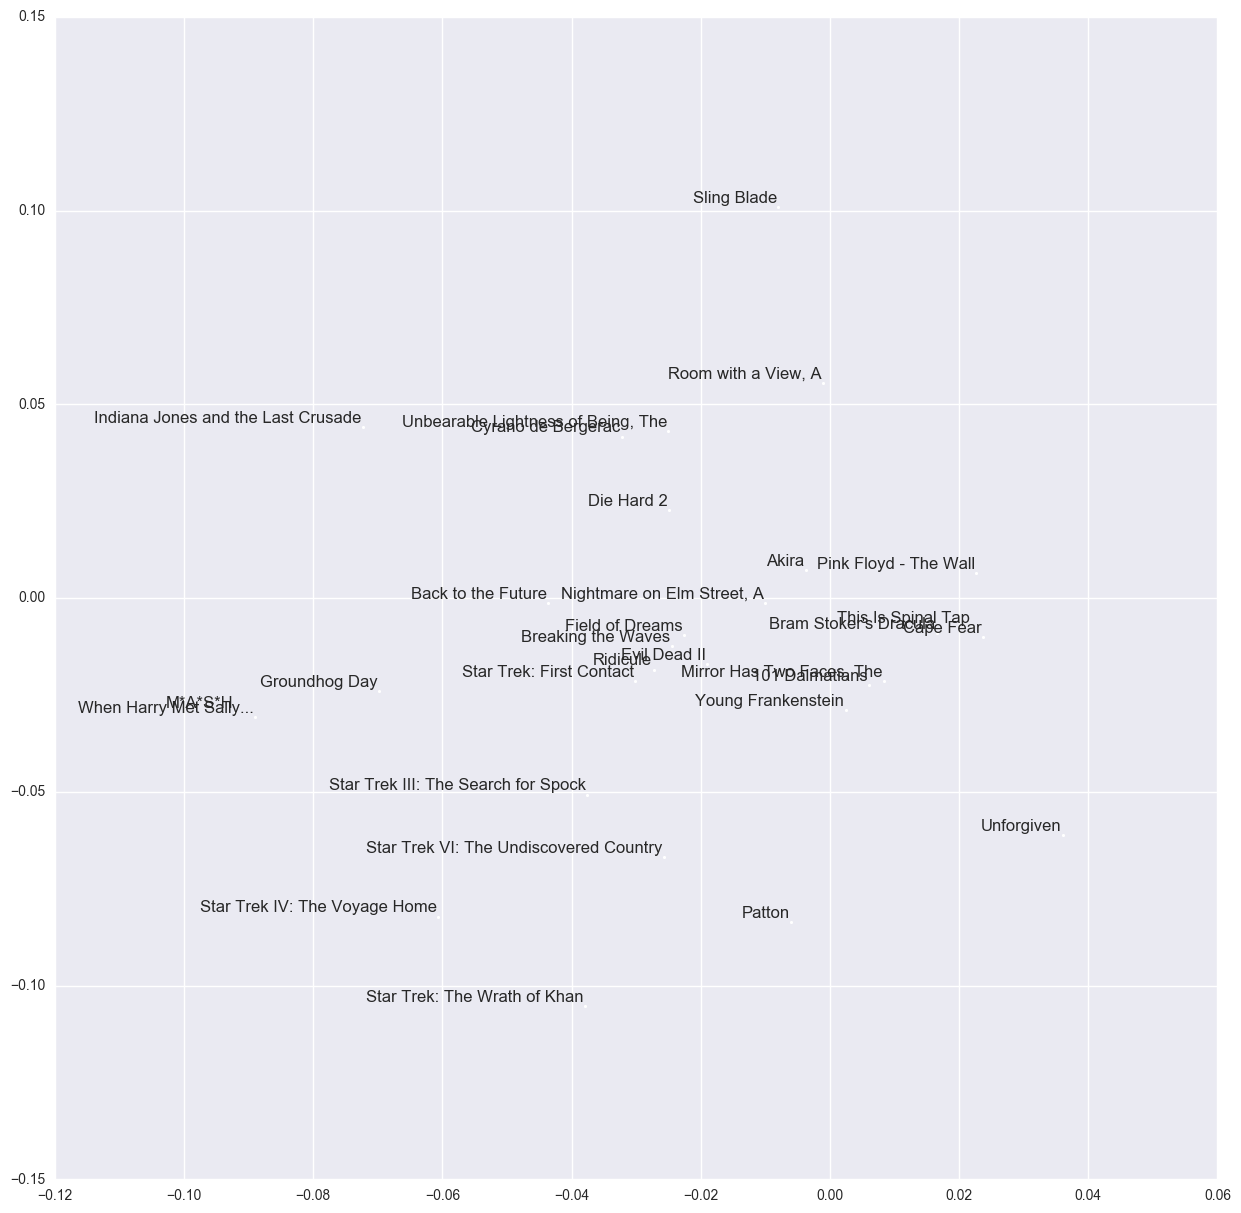

In [17]:
df_lv = pd.DataFrame(vt[:2,:].T, columns=['factor_1','factor_2'])
df_lv = pd.merge(df_lv, df_movies, how='left', left_index=True, right_index=True)
df_lv['movie title'] = df_lv['movie title'].map(lambda x: str(x)[:-7])
df_lv = df_lv[['factor_1','factor_2','movie title']].iloc[200:230]

plt.figure(figsize=(15,15))
plt.scatter(df_lv['factor_1'], df_lv['factor_2'], 
            c='white', marker='.',
            edgecolor='white',
            linewidth=0.0)

for label, x, y in zip(df_lv['movie title'], df_lv['factor_1'], df_lv['factor_2']):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-1, 1),
        textcoords='offset points', ha='right', va='bottom',
        )

plt.show()

### Comparison of both methods
I particulary like the second testing method - look at what movies the user liked and what we think he/she would like. Because in the end, what we want is to have relevant recommendations. 

Thus below, I randomly chosen few users and calculated top predictions.

In [18]:
#Let's recalculate the predictions
prediction_CF = predictCF(train, similarity_user, corated_user, direction='user')
prediction_MF, u, s, vt = predictMF(train, 20)

**User 56** - the both methods offer same movies except one (Fargo vs. Jerry Maguire - the second movie is Drame/Romance which seems to fit better to the taste of the user). MF gives better ratings.

In [22]:
print 'Collaborative filtering:'
topMovieRecommendation(prediction_CF, ratings, df_movies, 56)
print '\n'
print 'Matrix Factorization:'
topMovieRecommendation(prediction_MF, ratings, df_movies, 56)

Collaborative filtering:
Top 5 movies user 56 liked:
                movie title                       genre  rating
0          Toy Story (1995)  Animation,Childrens,Comedy     5.0
281  Time to Kill, A (1996)                       Drama     5.0
743  Michael Collins (1996)                   Drama,War     5.0
762    Happy Gilmore (1996)                      Comedy     5.0
78     Fugitive, The (1993)             Action,Thriller     5.0
--------------------------------------------
Top 5 predictions for user 56:
                       movie title                                genre  predicted rating
49                Star Wars (1977)  Action,Adventure,Romance,Sci-Fi,War          2.990832
180      Return of the Jedi (1983)  Action,Adventure,Romance,Sci-Fi,War          2.515219
99                    Fargo (1996)                 Crime,Drama,Thriller          2.330878
0                 Toy Story (1995)           Animation,Childrens,Comedy          2.226426
120  Independence Day (ID4) (1996)   

**User 873** - Both methods give same movies except one. CF propose Star Wars, whiles MF offers Secrets and Lies. Considering the top five movies the user liked, Secrets and Lies looks like a better choice.

In [23]:
print 'Collaborative filtering:'
topMovieRecommendation(prediction_CF, ratings, df_movies, 873)
print '\n'
print 'Matrix Factorization:'
topMovieRecommendation(prediction_MF, ratings, df_movies, 873)

Collaborative filtering:
Top 5 movies user 873 liked:
                  movie title                             genre  rating
653          Chinatown (1974)        Film-Noir,Mystery,Thriller     5.0
520   Deer Hunter, The (1978)                         Drama,War     5.0
301  L.A. Confidential (1997)  Crime,Film-Noir,Mystery,Thriller     5.0
513         Annie Hall (1977)                    Comedy,Romance     5.0
126     Godfather, The (1972)                Action,Crime,Drama     5.0
--------------------------------------------
Top 5 predictions for user 873:
                     movie title                                genre  predicted rating
99                  Fargo (1996)                 Crime,Drama,Thriller          2.914906
49              Star Wars (1977)  Action,Adventure,Romance,Sci-Fi,War          2.620433
285  English Patient, The (1996)                    Drama,Romance,War          2.472291
126        Godfather, The (1972)                   Action,Crime,Drama          2.1152

** User 431 **: Here, both prediction are completely different. Judging from the genres, MF seems to be slightly better, but it is not perfect either.

In [30]:
print 'Collaborative filtering:'
topMovieRecommendation(prediction_CF, ratings, df_movies, 331)
print '\n'
print 'Matrix Factorization:'
topMovieRecommendation(prediction_MF, ratings, df_movies,331)

Collaborative filtering:
Top 5 movies user 331 liked:
             movie title            genre  rating
1217       Friday (1995)           Comedy     5.0
832   Bulletproof (1996)           Action     5.0
293     Liar Liar (1997)           Comedy     5.0
692        Casino (1995)            Drama     5.0
287        Scream (1996)  Horror,Thriller     5.0
--------------------------------------------
Top 5 predictions for user 331:
                        movie title                                genre  predicted rating
49                 Star Wars (1977)  Action,Adventure,Romance,Sci-Fi,War          3.606839
180       Return of the Jedi (1983)  Action,Adventure,Romance,Sci-Fi,War          3.185356
173  Raiders of the Lost Ark (1981)                     Action,Adventure          2.883678
99                     Fargo (1996)                 Crime,Drama,Thriller          2.829525
0                  Toy Story (1995)           Animation,Childrens,Comedy          2.764812


Matrix Factorization:

### Conclusions
To wrap it up, we saw how Collaborative Filtering and Matrix Factorization behave. I like Collaborative Filtering, because is straightforward and the implementation is not difficult. I tried to improve it with co-rated weight, but without success. Even though the performance is quite low, judging by RMSE or the usefulness of predictions, the method has its place. Plus being sort of white-box model can be seen as another advantage.

The Matrix Factorization performed significantly better in both RMSE and usefulness of prediction. Thanks to the numpy implementation, the model is built pretty quickly. I also tried to improve the model by adding global and local biases, which was successful - plain Matrix Factorization gave RMSE of 2.5 and the improved version yielded RMSE equal to 1.2.

When both methods were compared by usefulness of prediction, Matrix Factorization always offered better recommendations (at least by me). I saw that Collaborative Filtering often recommended the most popular movies, whilst the second method is a bit more personalized. Interestingly, both models failed to predict item similarity. Lastly, I had to transform the ratings in Matrix Recommendation to 1-5 scale, which also improved the RMSE. Nevertheless, when I did the same in Collaboratiove Filtering, there was no effect.


### Next steps:
As it always is, there is so much more I did not take into account. That is why I added a few bulletpoints of ideas, which I believe can improve the performance and overall usefullness of the model.

  * **Testing**
    * Calculate the RMSE on top-n items would be more reasonable. Order of predictions, diversity or relevance is very important and should be tested as well. 
  * **Matrix Factorization**
    * In one of the articles I mentioned, there are other techniques such as ALS with gradient descent, which offerss better performance.
  * **Temporal dynamics**
    * This was one of the techniques that really helped the participants in the Netlix challenge - the idea is that some movies are temporary more popular. For example newly released or old movies tend to get higher ratings.
  * **Implicit ratings**
    * The obvious one - it is said that they are more powerful than explicit. Also, they are much more available.
  * **Hybrids**
    * This seems to be the thing everyone is doing now and it is the thing which won the competition. Some models are dealing better with cold start, some with biases etc. so the combination should perform better.